TODO:
Learn to use visualization techniques to study:
1. missing data
2. distributions
3. correlation heatmaps
4. pairplots,
5. t-SNE

pre-proc:
1. use catboost for categoric data

model: 


# JET House Prices Prediction 

# instruction
## Part 1:
[Model submission is done through Kaggle]
Part 1 - EDA
1. Which 3 features have the highest number of missing values
2. How the price behave over the years?
3. Plot the the feature distribution using histograms
4. Compute and order the features by their correlation with label
5. Add more EDA that will help you understand the data and support your modeling decisions

Part 2 - baseline
1. Train the simplest baseline model possible
2. submit your baseline results and share the results

## Part 2:
[Model submission is done through Kaggle]
Your solution:  go wild and build the best performing model!Which model you choose and why (relate to relevant EDA)?
Choose a validation creation process, why you choose it? what is the baseline performance?
Which smart tricks you used to boost your model performance?
Describe potential generalization issues (e.g. overfit/underfit)? How can you handle these?
submit your model and improve your rank in the leaderboard!

Deliverables
A final submission and score of you team in the leaderboard
Working and easy to follow notebook with the 3 parts completed and that produce your best submission.
Slides explaining your project: 
1. EDA
2. decision made
3. feature analysis
4. validation
5. modeling
6. etc



# Imports and loadings

In [1]:
#import tensorflow as tf
#import tensorflow_decision_forests as tfdf
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
import warnings

warnings.filterwarnings('ignore')

# Comment this if the data visualisations doesn't work on your side
%matplotlib inline

# general functions

In [2]:
def printt(df,Name=None,verbose=True):    
    if verbose==True:
        print('----------------------')
        if Name!=None:
            print(Name)
        print(df)

In [3]:
def plot_perd(y, y_pred,verbose=True):
    if verbose==True:
        plt.figure(figsize=(5, 5))
        plt.scatter(y, y_pred, color='blue')
        plt.title('True vs Predicted Values')
        plt.xlabel('True Values')
        plt.ylabel('Predicted Values')
        plt.plot([min(y), max(y)], [min(y), max(y)], color='red') # Line for perfect predictions
        plt.grid(True)
        plt.show()


# Load the dataset

In [4]:
test_file_path = "project/test.csv"
train_file_path = "project/train.csv"
testset_df = pd.read_csv(test_file_path)
dataset_df = pd.read_csv(train_file_path)
print("Full test set shape is {}".format(testset_df.shape))
print("Full train dataset shape is {}".format(dataset_df.shape))
id_file = testset_df['Id']
# Assuming 'dataset_df' is your DataFrame
y = dataset_df['SalePrice']
X = dataset_df.drop('SalePrice', axis=1)
# Splitting the dataset into training and testing sets
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=42)

Full test set shape is (1459, 80)
Full train dataset shape is (1460, 81)


The data is composed of 81 columns and 1460 entries. We can see all 81 dimensions of our dataset by printing out the first 3 entries using the following code:

# Pre proccessing functions

## drop ID

In [5]:
# Custom transformer to remove NAs
class drop_ID(BaseEstimator, TransformerMixin):
    def __init__(self, verbose=False):        
        self.verbose = verbose
    def fit(self, X, y=None):
        printt('','In drop_ID fit',verbose=self.verbose)
        return self

    def transform(self, X, y=None):
        printt(X.shape,'drop_ID in X.shape',verbose=self.verbose)
        # Ensure 'Id' column is removed safely
        if 'Id' in X.columns:
            return X.drop('Id', axis=1)
        else:
            return X

## NAs

In [6]:
def imput_mean_mode(X,mean_mode):
    # impute missing value by pre calc mean or mode :
    col_numeric = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
    col_object = X.select_dtypes(include=['O']).columns.tolist()
    # save the mean and the mode for later imputation
    combined_stats = pd.Series(dtype=object)
    for col in X.columns:        
        X[col].fillna(mean_mode[col], inplace=True)
    return X

In [7]:
def calc_mean_mode(X):
    # find the mean of numrical columns and the mode of object columns
    # return :
    # combined_stats = mean amd mode in the same shape as orign,
    # col_numeric,col_object =list of numeric and obkect coumln names
    col_numeric = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
    col_object = X.select_dtypes(include=['O']).columns.tolist()
    printt(col_numeric,'col_numeric',False)
    printt(col_object,'col_object',False)
    # save the mean and the mode for later imputation
    means = X[col_numeric].mean()
    modes = X[col_object].mode().iloc[0]
    # Step 3: Combine results, maintaining the original arrangement
    combined_stats = pd.Series(dtype=object)
    for col in X.columns:
        if col in means:
            combined_stats[col] = means[col]
        elif col in modes:
            combined_stats[col] = modes[col]
    return combined_stats,col_numeric,col_object

In [8]:
def find_bad_col(X,threshold=None,verbose=False):
    # drop col with na in amount more than threshold
    if threshold is not None:
        thresh = len(X)*threshold//1        
        na_counts    = X.isna().sum()
        columns_to_keep_ = na_counts[na_counts < thresh].index
        columns_to_remove_ = na_counts[na_counts >= thresh].index
    else:
        columns_to_keep_ = X.columns
        columns_to_remove_ = pd.Index([])        

    if verbose==True:
        nan_counts  = X.isna().sum().sort_values(ascending=False).head(20)/len(X)*100
        print(f"features with the highest number of missing values in %")
        print(f"{nan_counts}%")
        printt(len(columns_to_keep_),'len(columns_to_keep_)',verbose=verbose)
        printt(len(columns_to_remove_),'len(columns_to_remove_)',verbose=verbose)
        if len(columns_to_remove_)>0:
            printt(columns_to_remove_,'columns_to_remove_',verbose=verbose)           

    return columns_to_keep_,columns_to_remove_


In [9]:
def print_row_nan_counts(X,verbose=False):
    # print number of Rows with missing values
    row_nan_counts = X.isna().sum(axis=1) 
    top_row_nan_counts = row_nan_counts.sort_values(ascending=False)
    if verbose==True:
        print("number of Rows with missing values:")
        print(top_row_nan_counts.value_counts())


In [10]:
def print_missingVal_groups(X,verbose=False):
    row_nan_counts = X.isna().sum(axis=1) 
    rows_with_missing_values = X[row_nan_counts >0]
    unique_missing_column_groups = set()
    # Iterate through rows and identify unique groups of missing columns
    for _, row in rows_with_missing_values.iterrows():
        # Extract groups of 5 columns
        groups = tuple(row.index[row.isna()])
        # Add the unique group to the set
        unique_missing_column_groups.add(groups)
    
    # Sort the unique groups by their length
    sorted_unique_missing_column_groups = sorted(unique_missing_column_groups, key=lambda x: len(x))
    # Print the unique groups of 5 missing columns
    if verbose==True:
        print('\nmissing values groups:')
        for i, group in enumerate(sorted_unique_missing_column_groups, start=1):
            print(f"Group {i} of {len(group)} missing columns: {group}")

In [11]:
class remove_NAs_col(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=None,verbose=False):        
        self.threshold = threshold  # Minimum non-NA values required to keep a column
        self.verbose = verbose
    def fit(self, X, y=None):
        printt('','In RemoveNAs Col fit',verbose=self.verbose)
        # If threshold is set, identify columns to keep based on the threshold
        self.columns_to_keep_,self.columns_to_remove_ = find_bad_col(X,self.threshold,self.verbose)
        return self
    
    def transform(self, X, y=None):
        printt('','In RemoveNAs Col transform',verbose=self.verbose)
        # Drop columns not meeting the threshold requirement
        printt(X.shape,'X.shape',verbose=self.verbose)
        X_transformed = X.loc[:, self.columns_to_keep_]
        printt(X_transformed.shape,'X_transformed.shape',verbose=self.verbose)        
        return X_transformed

In [12]:
class imput_NAs_row(BaseEstimator, TransformerMixin):
    def __init__(self, verbose=False):        
        self.column_means_ = None
        self.verbose = verbose
        self.col_numeric = None
        self.col_object = None
    def fit(self, X, y=None):
        printt('','In imput_NAs_row fit',verbose=self.verbose)
        # Calculate mean values for each column, ignoring NA's
        printt(X.shape,'imput_NAs_row in X.shape',verbose=self.verbose)
        # save the mean and the mode for later imputation
        self.mean_mode,self.col_numeric,self.col_object = calc_mean_mode(X)
        print_row_nan_counts(X,verbose=self.verbose)
        print_missingVal_groups(X,verbose=self.verbose)        
        return self
    
    def transform(self, X, y=None):
        printt('','In imput_NAs_row transform',verbose=self.verbose)
        printt(X.shape,'X.shape',verbose=self.verbose)
        print_row_nan_counts(X,verbose=self.verbose)

        printt('','filing Garage and Bsmt',verbose=self.verbose)
        # Replace NaN values in the specified columns for rows where 'TotalBsmtSF' is equal to 0 with 'NotExist'
        basement_list = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
        Garage_list = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
        X.loc[X['TotalBsmtSF'] == 0, basement_list] = X.loc[X['TotalBsmtSF'] == 0, basement_list].fillna('NotExist')
        X.loc[X['GarageArea'] == 0, Garage_list] = X.loc[X['GarageArea'] == 0, Garage_list].fillna('NotExist')
        print_row_nan_counts(X,verbose=self.verbose)
        # special imputation
        printt('','special imputation',verbose=self.verbose)
        X['GarageYrBlt'].fillna(X['YearBuilt'], inplace=True)        
        X['BsmtFinType2'].fillna('NotExist', inplace=True)
        X['BsmtExposure'].fillna('NotExist', inplace=True)
        print_row_nan_counts(X,verbose=self.verbose)

        printt('','imput_mean_mode',verbose=self.verbose)
        X = imput_mean_mode(X,self.mean_mode)
        print_row_nan_counts(X,verbose=self.verbose)
        return X

## handle categorical

In [13]:
def print_categoric(X,y,verbose=False):
    col_object = X.select_dtypes(include=['O']).columns.tolist()
    for col in col_object:
        printt('',col)        
        vals = X[col].unique()        
        print()
        cols = [col for _ in range(len(vals))]  # This will create a list with 'title' repeated
        #print('\n'.join(str(val) for val in vals))
        if 0:
            print(np.mean(np.log(y[X[col] == 'TA'])))
            print(np.mean(np.log(y[X[col] == 'Gd'])))
            print(np.mean(np.log(y[X[col] == 'Ex'])))
            print(np.mean(np.log(y[X[col] == 'Fa'])))
        ymean  = [np.mean(np.log(y[X[col] == val]))  for val in vals]
        ystd   = [np.std(np.log(y[X[col] == val]))   for val in vals]
        ratios = [np.mean(X[col] == val)*100         for val in vals]
        numbers = [np.sum(X[col] == val)             for val in vals]

        df = pd.DataFrame({'col': cols, 'val': vals, 'ymean': ymean, 'ystd': ystd,'number': numbers, 'ratio': ratios})
        df.loc[pd.isna(vals), 'ratio'] = np.mean(X[col].isna())*100
        df.loc[pd.isna(vals), 'number'] = np.sum(X[col].isna())
        df.loc[pd.isna(vals), 'ymean'] = np.mean(np.log(y[X[col].isna()]))
        df.loc[pd.isna(vals), 'ystd'] = np.std(np.log(y[X[col].isna()]))
        
        # This will apply the formatting and then convert the DataFrame to a string for printing
        formatted_df_string = df.to_string(formatters={'ymean': "{:.2f}".format, 'ystd': "{:.2f}".format, 'ratio': "{:.2f}".format})
        print(formatted_df_string)        

print_categoric(X[['ExterQual']],y,True)



----------------------
ExterQual


         col val ymean ystd  number ratio
0  ExterQual  Gd 12.31 0.29     488 33.42
1  ExterQual  TA 11.84 0.29     906 62.05
2  ExterQual  Ex 12.76 0.32      52  3.56
3  ExterQual  Fa 11.30 0.39      14  0.96


In [14]:
def replace_qual_categoric(X,y=None,verbose=False):
# Assuming X is your DataFrame

    category_sets = [
        set(['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NotExist']),
        set(['Gd', 'Av', 'Mn', 'No', 'NotExist']),
        set(['GLQ','ALQ','BLQ','Rec','LwQ','Unf','NotExist']),
        set(['Fin','RFn','Unf','NotExist']),
        set(['GdPrv','MnPrv','GdWo','MnWw','NotExist']),
    ]
    titles = ['quality_mapping', 'access_mapping', 'basement_mapping', 'garage_mapping', 'fence_mapping']
    
    # Mappings
    quality_mapping = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NotExist': 0}
    access_mapping = {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'NotExist': 0}
    basement_mapping = {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'NotExist': 0}
    garage_mapping = {'Fin': 3, 'RFn': 2, 'Unf': 1, 'NA': 0}
    fence_mapping = {'GdPrv': 4, 'MnPrv': 3, 'GdWo': 2, 'MnWw': 1, 'NotExist': 0}
    
    # Mapping from titles to actual mappings
    mapping_dict = {
        'quality_mapping': quality_mapping,
        'access_mapping': access_mapping,
        'basement_mapping': basement_mapping,
        'garage_mapping': garage_mapping,
        'fence_mapping': fence_mapping,
    }
    
    # Select columns of object type
    col_object = X.select_dtypes(include=['O']).columns.tolist()
    
    matching_categories = {}
    for col in col_object:
        vals = set(X[col].unique())
        # Check which category set vals belongs to
        for index, category_set in enumerate(category_sets):
            if vals.issubset(category_set):  # Check if all elements of vals are in the category_set
                matching_categories[col] = titles[index]                
                break  # Exit the loop if a matching set is found

    # Apply the matched mappings to the columns
    X_ = X.copy()
    for col, title in matching_categories.items():
        if title in mapping_dict:
            X_[col] = X[col].map(mapping_dict[title])

    if verbose==True:
        printt(len(matching_categories),'matching_categories')
        print(list(matching_categories.keys()))
        for col, title in matching_categories.items():
            if y is not None and not y.empty:
                print_categoric(X[[col]],y,True)
            print(f"{col}: {title} : {mapping_dict[title]}")
    
    return X_

#replace_qual_categoric()
if 0:
    order_col = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'GarageFinish', 'GarageQual', 'GarageCond']
    columns_to_keep_,columns_to_remove_ = find_bad_col(X,.15)
    Xnew = X.loc[:, columns_to_keep_]
    print(Xnew.shape)
    imp = imput_NAs_row()
    imp.fit(Xnew)
    Xnew = imp.transform(Xnew)
    print(Xnew.shape)
    X_ = replace_qual_categoric(Xnew[order_col],y,verbose=True)
    Xnew.shape,X_.shape


In [15]:
class handle_categoric(BaseEstimator, TransformerMixin):
    def __init__(self,verbose=False,drop_categoric=False):        
        self.col_numeric = None
        self.verbose = verbose
        self.col_object = None
        self.drop_categoric = drop_categoric
    def fit(self, X,y=None):
        printt('','In categoric fit',verbose=self.verbose)
        self.col_numeric = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
        self.col_object = X.select_dtypes(include=['O']).columns.tolist()

        #print_categoric(X)
        
        return self
    
    def transform(self, X):
        # for now remove all categoric TODO: improve this
        printt('','In categoric transform',verbose=self.verbose)
        printt(X.shape,'X.shape',verbose=self.verbose)

        if self.drop_categoric=='KeepJustOrdered' :
            X = replace_qual_categoric(X,verbose=self.verbose)
            col_numeric = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
            left_objects = len(X.select_dtypes(include=['O']).columns.tolist())
            printt('',f'number of num feature befor {len(self.col_numeric)}, added {len(col_numeric) - len(self.col_numeric)}, left_objects: {left_objects}',verbose=self.verbose)
            X = X.loc[:, col_numeric]
            
        if self.drop_categoric=='DropAll':
            col_numeric = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
            X = X.loc[:, col_numeric]

        #printt(len(X.select_dtypes(include=['O']).columns.tolist()),'length Object')
        #print(X.select_dtypes(include=['O']).columns.tolist())
        return X

## terget_manipulation

In [16]:
def terget_manipulation(y,take_log_target=0,verbose=False):      
        if take_log_target==0:                                    
            if verbose==True:
                print('no log on target')
            return y
        if take_log_target==1:                        
            if verbose==True:
                print('take log on target')
            return np.log(y)
        if take_log_target==-1:                        
            if verbose==True:
                print('un-do log on target')
            return np.exp(y)

# Config params

In [17]:
Config_params = dict()
Config_params['nan_counts_threshold'] = .15
Config_params['filter_out_HighNA'] = 1
Config_params["model"]='decisionTree' #'decisionTree','CatBoost'
Config_params["drop_categoric"] = 'KeepAll' #'KeepAll','KeepJustOrdered','DropAll'
Config_params["take_log_target"]=0 # 0,1
Config_params["verbose"]=False # False,True

# pipeline

In [18]:
# Function to create and return a pipeline based on the configuration
def create_pipeline(config_params):
    verbose = Config_params["verbose"]

    # Dynamically select the model based on config_params
    printt(Config_params['model'],'Model',verbose=verbose)
    if config_params['model'] == 'DecisionTree':
        model = DecisionTreeRegressor(random_state=42)
    elif config_params['model'] == 'CatBoost':
        #
        if config_params['drop_categoric'] == 'KeepAll':
            categorical_columns = X.select_dtypes(include=['O']).columns.tolist()
            categorical_columns = ['MSZoning', 'Street', 'LotShape', 'LandContour',
                               'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
                               'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
                               'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
                               'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
                               'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
                               'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
                               'Functional', 'GarageType', 'GarageFinish', 'GarageQual',
                               'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition']
            model = CatBoostRegressor(random_seed=42, silent=True, cat_features = categorical_columns)
        else:
            model = CatBoostRegressor(random_state=42, verbose=int(verbose))  # Adjust verbosity for CatBoost
        #printt(len(categorical_columns),'length categorical_columns')
        #print(categorical_columns)
        


    pipeline = Pipeline([
        ('drop_ID', drop_ID(verbose=verbose)),
        ('remove_nas_col', remove_NAs_col(threshold=config_params['nan_counts_threshold'], verbose=verbose)),
        ('imput_nas_row', imput_NAs_row(verbose=verbose)),
        ('handle_categoric', handle_categoric(drop_categoric=config_params['drop_categoric'], verbose=verbose)),
        ('reg', model)  # Use the dynamically selected model
    ])
    
    return pipeline


Pipeline created for model: CatBoost, drop_categoric: DropAll
rms = 27362.21, logRMS = 10.22
Pipeline created for model: CatBoost, drop_categoric: KeepJustOrdered
rms = 27938.34, logRMS = 10.24
Pipeline created for model: CatBoost, drop_categoric: KeepAll
rms = 24917.52, logRMS = 10.12


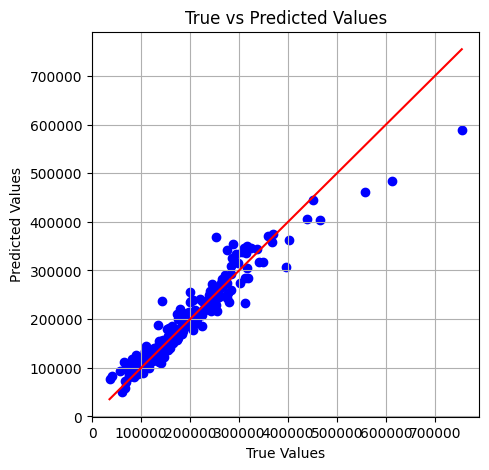

In [19]:
# Iterate over all combinations
models = ['CatBoost'] #['DecisionTree', 'CatBoost']
drop_categoric_options = ['DropAll','KeepJustOrdered','KeepAll'] #'KeepAll','KeepJustOrdered','DropAll'

for model in models:
    for drop_categoric in drop_categoric_options:
        Config_params["model"] = model
        Config_params["drop_categoric"] = drop_categoric
        pipeline = create_pipeline(Config_params)
        print(f"Pipeline created for model: {model}, drop_categoric: {drop_categoric}")
        # Add your code here to train the pipeline or to print further details

        new_y = terget_manipulation(y_train,take_log_target=Config_params['take_log_target'])

        pipeline.fit(X_train,new_y)
        y_pred = pipeline.predict(X_validation)

        y_pred = terget_manipulation(y_pred,take_log_target=-1*Config_params['take_log_target'],verbose=Config_params["verbose"])
        # check errors
        rms = np.sqrt(mean_squared_error(y_validation, y_pred))        
        print(f"rms = {rms:.2f}, logRMS = {np.log(rms):.2f}")

if 0: print('\n'.join(f"{col}: {title}" for col, title in Config_params.items()))

plot_perd(y_validation, y_pred,True)


# Submission
Finally predict on the competition test data using the model.

In [20]:
# fit again now on full data_set to improve results
pipeline.fit(X,y)
# predinct on test
y_pred = pipeline.predict(testset_df)
output = pd.DataFrame({'Id': id_file,
                       'SalePrice': y_pred.squeeze()})
# create CSV
output.to_csv('./project/submission.csv', index=False)
output.head()

,Id,SalePrice
0,1461,116804.917550
1,1462,161706.005026
2,1463,188186.589387
3,1464,191363.116421
4,1465,186629.846975
